In [64]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re
import json

import nltk
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
from google.oauth2 import service_account # based on google-auth library
import sddk

In [66]:
publicfolder = "8fe7d59de1eafe5f8eaebc0044534606"
morpheus_by_lemma = json.loads(requests.get("https://sciencedata.dk/public/" + publicfolder + "/morpheus_by_lemma.json").content)

In [2]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

In [3]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [4]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [5]:
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_hippocraticum = sddk.read_file("c_hippocraticum_enriched.json", "df", publicfolder)

reading file located in a public folder


In [8]:
c_hippocraticum.columns

Index(['filename', 'author', 'title', 'wordcount', 'author_id', 'doc_id',
       'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience',
       'tlg_epithet', 'clean_string', 'sentences', 'n_sentences',
       'lemmatized_sentences', 'lemmata', 'lemmata_wordcount', 'lemmata_repl',
       'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*',
       'terms_sum', 'λύπ*_TF', 'ἄλγ*_TF', 'ὀδύν*_TF', 'πόνο*_TF', 'TF_sum',
       'work_cat_jouanna', 'work_cat_craik', 'work_cat_linka'],
      dtype='object')

In [11]:
# the viper is out!!!
c_hippocraticum["lemmata_repl"].apply(lambda x: x.count("ἔχις")).sum()

0

In [12]:
words = ['λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']

In [13]:
def sentences_with_term(sentences, term, flatlist=False):
    sentences_with_term = [sen for sen in sentences if term in sen]
    if flatlist == True:
        flatlist = [word for sen in sentences_with_term for word in sen]
        return flatlist
    else: 
        return sentences_with_term

In [14]:
for word in words:
    c_hippocraticum[word + "_sents"] = c_hippocraticum["lemmatized_sentences_repl"].apply(lambda x: sentences_with_term(x, word, True))

In [15]:
for word in words:
    c_hippocraticum[word + "_sents"] = c_hippocraticum[word + "_sents"].apply(lambda sentences:  [word for word in sentences if word not in ["ἢν", "ὁκόταν"]])

In [26]:
all_sents = [sent for doc_sents in c_hippocraticum["lemmatized_sentences_repl"].tolist() for sent in doc_sents]
len(all_sents)

24456

In [27]:
print(all_sents[:3])

[['ὁπόσος', 'ἐπιχειρέω', 'ἰητρικῆς', 'λέγω', 'γράφω', 'ὑπόθεσις', 'αὐτός', 'ὑποθέμενοι', 'λόγος', 'θερμός', 'ψυχρός', 'ὑγρός', 'ξηρός', 'ἄλλος', 'τὶς', 'ἐθέλω', 'βραχύς', 'ἄγω', 'ἀρχή', 'αἰτία', 'ἄνθρωπος', 'νοῦσος', 'θάνατος', 'πᾶς', 'αὐτός', 'εἷς', 'δύο', 'ὑποθέμενοι', 'πολύς', 'λέγω', 'καταφανής', 'εἰμί', 'ἁμαρτάνω', 'ἄξιος', 'μέμφομαι', 'τέχνη', 'εἰμί', 'χράω', 'πᾶς', 'μέγας', 'τιμάω', 'ἀγαθός', 'χειροτέχνης', 'δημιουργός'], ['δημιουργός', 'φαῦλος', 'πολύς', 'διαφέροντες'], ['εἰμί', 'ἰατρικός', 'ἔσκεπτο', 'εὑρίσκω', 'μηδείς', 'εἰμί', 'πᾶς', 'ἄπειρος', 'ἀνεπιστήμων', 'εἰμί', 'τύχη', 'κάμνω', 'διοικεῖτο']]


In [16]:
wordlists = {}
for word in words:
    corpus_wordlist = []
    for wordlist in c_hippocraticum[word + "_sents"]:
        corpus_wordlist.extend(wordlist)
    wordlists[word] = corpus_wordlist

In [50]:
wordlists_freqs = {}
for word in words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    word_freqs = [(tup[0], np.round(tup[1] / word_count, 5)) for tup in word_counts]
    wordlists_freqs[word + " word"] = [tup[0] for tup in word_counts]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* word,ἄλγ* word,ὀδύν* word,πόνο* word
0,λύπ*,ἄλγ*,ὀδύν*,πόνο*
1,εἰμί,πυρετός,ἔχω,γίγνομαι
2,γίγνομαι,κεφαλή,γίγνομαι,πολύς
3,ἄνθρωπος,εἰμί,εἰμί,εἰμί
4,σῶμα,γίγνομαι,πυρετός,σῶμα
5,πολύς,ἔχω,πολύς,ἔχω
6,οὗτος,ὀδύν*,κεφαλή,οὗτος
7,αὐτός,κοιλία,γαστήρ,ἄλλος
8,κοιλία,γαστήρ,ἴσχω,κοιλία
9,ἡμέρα,ὀσφῦς,οὗτος,πυρετός


In [53]:
unique_words = []
for col in wordlists_freqs_df.columns:
    unique_words.extend(wordlists_freqs_df[col].tolist())
unique_words = list(set(unique_words))

In [54]:
wordlists_freqs = {}
for word in words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    c_hippocraticum[word + "_sents"]
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    word_freqs = [(tup[0], np.round(tup[1] / word_count, 5)) for tup in word_counts]
    wordlists_freqs[word + " (n={0})".format(word_counts[0][1]) ] = word_freqs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* (n=58),ἄλγ* (n=316),ὀδύν* (n=642),πόνο* (n=657)
0,"(εἰμί, 0.03528)","(πυρετός, 0.01656)","(ἔχω, 0.02301)","(γίγνομαι, 0.02061)"
1,"(γίγνομαι, 0.02171)","(κεφαλή, 0.01656)","(γίγνομαι, 0.02249)","(πολύς, 0.01798)"
2,"(ἄνθρωπος, 0.01628)","(εἰμί, 0.01656)","(εἰμί, 0.01448)","(εἰμί, 0.01593)"
3,"(σῶμα, 0.01628)","(γίγνομαι, 0.01656)","(πυρετός, 0.01422)","(σῶμα, 0.0152)"
4,"(πολύς, 0.01493)","(ἔχω, 0.01629)","(πολύς, 0.01331)","(ἔχω, 0.01096)"
5,"(οὗτος, 0.01221)","(ὀδύν*, 0.01222)","(κεφαλή, 0.0115)","(οὗτος, 0.01023)"
6,"(αὐτός, 0.01085)","(κοιλία, 0.01113)","(γαστήρ, 0.01034)","(ἄλλος, 0.00936)"
7,"(κοιλία, 0.0095)","(γαστήρ, 0.0095)","(ἴσχω, 0.00801)","(κοιλία, 0.00848)"
8,"(ἡμέρα, 0.00814)","(ὀσφῦς, 0.00923)","(οὗτος, 0.00724)","(πυρετός, 0.00848)"
9,"(ἄλλος, 0.00814)","(οὗτος, 0.00842)","(παρέχω, 0.00685)","(πᾶς, 0.00731)"


In [56]:
#set_with_dataframe(PIA_overview.add_worksheet("tfs-in-sentences", 1, 1), wordlists_freqs_df)

In [57]:
wordlists_freqs = {}
for word in words:
    word_counts = nltk.FreqDist(wordlists[word]).most_common(21)
    c_hippocraticum[word + "_sents"]
    word_count = c_hippocraticum[word + "_sents"].apply(lambda x: len(x)).sum()
    tfs = [np.round(tup[1] / word_count, 5) for tup in word_counts]
    tf_words = [tup[0] for tup in word_counts]
    wordlists_freqs[word + " words"] = tf_words[1:]
    wordlists_freqs[word + " TFs"] = tfs[1:]
wordlists_freqs_df = pd.DataFrame(wordlists_freqs)
wordlists_freqs_df

,λύπ* words,λύπ* TFs,ἄλγ* words,ἄλγ* TFs,ὀδύν* words,ὀδύν* TFs,πόνο* words,πόνο* TFs
0,εἰμί,0.03528,πυρετός,0.01656,ἔχω,0.02301,γίγνομαι,0.02061
1,γίγνομαι,0.02171,κεφαλή,0.01656,γίγνομαι,0.02249,πολύς,0.01798
2,ἄνθρωπος,0.01628,εἰμί,0.01656,εἰμί,0.01448,εἰμί,0.01593
3,σῶμα,0.01628,γίγνομαι,0.01656,πυρετός,0.01422,σῶμα,0.01520
4,πολύς,0.01493,ἔχω,0.01629,πολύς,0.01331,ἔχω,0.01096
5,οὗτος,0.01221,ὀδύν*,0.01222,κεφαλή,0.01150,οὗτος,0.01023
6,αὐτός,0.01085,κοιλία,0.01113,γαστήρ,0.01034,ἄλλος,0.00936
7,κοιλία,0.00950,γαστήρ,0.00950,ἴσχω,0.00801,κοιλία,0.00848
8,ἡμέρα,0.00814,ὀσφῦς,0.00923,οὗτος,0.00724,πυρετός,0.00848
9,ἄλλος,0.00814,οὗτος,0.00842,παρέχω,0.00685,πᾶς,0.00731


In [58]:
cats = c_hippocraticum["work_cat_linka"].unique().tolist()
cats

['Theoretical', 'Other', 'Practical']

In [59]:
most_common = []
for word in words:
    wordlist = wordlists_freqs_df[word + " words"].tolist()
    most_common.extend(wordlist)
most_common_unique = list(set(most_common))
most_common_unique_df = pd.DataFrame(most_common_unique)

In [83]:
terms_by_cat_df = get_as_dataframe(PIA_overview.worksheet("terms_by_cat"))
terms_by_cat_dict = dict(zip(terms_by_cat_df["term"], terms_by_cat_df["term_category"]))
terms_by_cat_dict

{'πρότερος': 'temporal quality',
 'ψυχρός': 'quality',
 'λαμβάνω': 'verb',
 'κεφαλή': 'bodily parts and constituents',
 'ἰσχυρός': 'quality',
 'ἄνθρωπος': 'bodily parts and constituents',
 'χολή': 'bodily parts and constituents',
 'ὁπόσος': 'quality',
 'ἄλγ*': 'pain-word',
 'τρίτος': 'temporal quality',
 'πᾶς': 'quality',
 'πλείων': 'quality',
 'σάρξ': 'bodily parts and constituents',
 'συμβαίνω': 'verb',
 'θερμός': 'quality',
 'μαλλός': 'quality',
 'ἡμέρα': 'temporal quality',
 'πόνο*': 'pain-word',
 'ὀδύν*': 'pain-word',
 'κοιλία': 'bodily parts and constituents',
 'εἶμι': 'verb',
 'ποιέω': 'verb',
 'γίγνομαι': 'verb',
 'ἔχω': 'verb',
 'καθίημι': 'verb',
 'δοκέω': 'verb',
 'δίδωμι': 'verb',
 'ὀξύς': 'quality',
 'πολύς': 'quality',
 'μήτρα': 'bodily parts and constituents',
 'ἰξύς': 'bodily parts and constituents',
 'κενεών': 'bodily parts and constituents',
 'χρόνος': 'temporal quality',
 'σιτίον': 'pathological state',
 'ἴσχω': 'verb',
 'ἐσθίω': 'verb',
 'νόσος': 'pathological state

In [84]:
terms_by_cat_dict.keys()

dict_keys(['πρότερος', 'ψυχρός', 'λαμβάνω', 'κεφαλή', 'ἰσχυρός', 'ἄνθρωπος', 'χολή', 'ὁπόσος', 'ἄλγ*', 'τρίτος', 'πᾶς', 'πλείων', 'σάρξ', 'συμβαίνω', 'θερμός', 'μαλλός', 'ἡμέρα', 'πόνο*', 'ὀδύν*', 'κοιλία', 'εἶμι', 'ποιέω', 'γίγνομαι', 'ἔχω', 'καθίημι', 'δοκέω', 'δίδωμι', 'ὀξύς', 'πολύς', 'μήτρα', 'ἰξύς', 'κενεών', 'χρόνος', 'σιτίον', 'ἴσχω', 'ἐσθίω', 'νόσος', 'σῶμα', 'ὀσφύς', 'ὀλίγος', 'παύω', 'γαστήρ', 'αἷμα', 'πυρετός', 'ὀφθαλμός', 'οὗτος', 'ἄλλος', 'αὐτός', 'εἰμί', 'λύπ*', 'ὀσφῦς', 'παρέχω'])

In [85]:
#words_for_coding = [word for word in unique_words if word not in terms_by_cat_dict.keys()]
#set_with_dataframe(PIA_overview.add_worksheet("words_for_coding_20201202", 1, 1), pd.DataFrame(words_for_coding))

In [86]:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
import matplotlib.colors as mcolors
colors_list = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
print(colors_list)

['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']


In [87]:
# remove white
colors_list = [col for col in colors_list if col not in ["b", "w"]] 

In [88]:
term_cats = list(set(terms_by_cat_dict.values()))
print(term_cats)

['quality', 'verb', 'temporal quality', 'pain-word', 'pathological state', 'adj', 'bodily parts and constituents']


In [91]:
colors = ["purple", "blue", "green", "black", "red", "grey","yellow"]
cat_colors_dict = dict(zip(term_cats, colors))
cat_colors_dict

{'quality': 'purple',
 'verb': 'blue',
 'temporal quality': 'green',
 'pain-word': 'black',
 'pathological state': 'red',
 'adj': 'grey',
 'bodily parts and constituents': 'yellow'}

In [92]:
cat_colors_dict["bodily parts and constituents"] #terms_by_col_dict[key]]

'yellow'

In [93]:
cat_colors_dict[terms_by_cat_dict["γίγνομαι"]]

'blue'

In [94]:
terms_by_col_dict = {}
for key in terms_by_cat_dict.keys():
    #print(key)
    terms_by_col_dict[key] = cat_colors_dict[terms_by_cat_dict[key]]

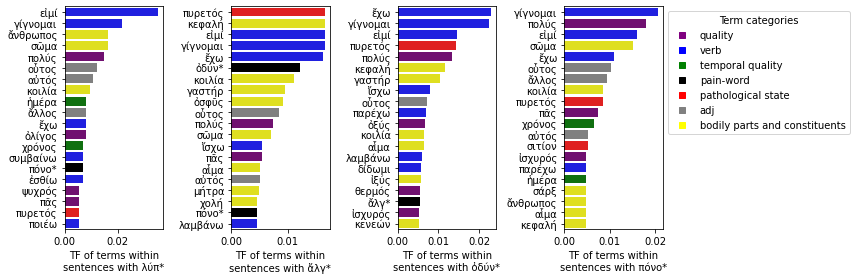

In [95]:
#plt.rcParams['figure.figsize'] = [12, 4]
fig, axs = plt.subplots(1, 4, figsize=[12,4], tight_layout=True)

for word, ax in zip(words, axs):
    xcol = wordlists_freqs_df[word + " TFs"]
    ycol = wordlists_freqs_df[word + " words"]
    actual_colors = [terms_by_col_dict[word] for word in ycol]
    sns.barplot(x=xcol, y=ycol, palette=actual_colors, ax=ax)
    ax.set(ylabel="", xlabel="TF of terms within\nsentences with " + word)

plt.subplots_adjust(hspace=0.08) # top=1, bottom=0, left=0, right=1, hspace=0.08, wspace=1.2)

#plt.title("Most frequent terms in sentences containing pain-words                       ", loc="right")

markers = [plt.Line2D([0,0],[0,0],color=color, marker="s", linestyle="") for color in colors]
plt.legend(markers, term_cats, numpoints=1,  title="Term categories", bbox_to_anchor=(1, 1), loc='upper left')

In [96]:
sddk.write_file("public_data/PIA/terms_in_sentences_20201207.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/terms_in_sentences_20201207.png"


https://sciencedata.dk/public/31b393e2afe1ee96ce81869c7efe18cb/terms_in_sentences_20201207.png

In [97]:
len(all_sents)

24456

# TFIDF

In [135]:
def term_idf(term):
    idf_raw =  len(all_sents) / len([sent for sent in all_sents if term in sent])
    idf_log = math.log(idf_raw)
    return idf_log
#authors_df["dik_sents_TFIDF"] = authors_df.apply(lambda x: get_tfidf(x["dik_sents_flat"], x["lemmatized_sentences"]), axis=1)

In [136]:
pain_words_sents = {}
for col in [col for col in c_hippocraticum.columns if "*_sents" in col]:
    pain_words_sents[col.partition("_")[0] + "_all_sents"] = {}
    list_of_lists = c_hippocraticum[col].tolist()
    words = [word for doc in list_of_lists for word in doc if word != col.partition("_")[0]]
    word_counts = nltk.FreqDist(words).most_common()
    FD = [(tup[0] , np.round(tup[1]  / len(words), 5)) for tup in word_counts]
    TFIDF = [(tup[0], np.round(tup[1] * term_idf(tup[0]), 5)) for tup in FD]
    TFIDF = sorted(TFIDF, key=lambda tup: tup[1], reverse=True)    
    pain_words_sents[col.partition("_")[0] + "_all_sents"] = {"words" : words, "word_counts" : word_counts, "FD" : FD, "TFIDF": TFIDF}

In [137]:
pain_words_sents.keys()

dict_keys(['λύπ*_all_sents', 'ἄλγ*_all_sents', 'ὀδύν*_all_sents', 'πόνο*_all_sents'])

In [138]:
pain_words_sents["λύπ*_all_sents"]["FD"]

[('εἰμί', 0.03829),
 ('γίγνομαι', 0.02356),
 ('ἄνθρωπος', 0.01767),
 ('σῶμα', 0.01767),
 ('πολύς', 0.0162),
 ('οὗτος', 0.01325),
 ('αὐτός', 0.01178),
 ('κοιλία', 0.01031),
 ('ἡμέρα', 0.00884),
 ('ἄλλος', 0.00884),
 ('ἔχω', 0.00884),
 ('ὀλίγος', 0.00884),
 ('χρόνος', 0.00736),
 ('συμβαίνω', 0.00736),
 ('πόνο*', 0.00736),
 ('ἐσθίω', 0.00736),
 ('ψυχρός', 0.00589),
 ('πᾶς', 0.00589),
 ('πυρετός', 0.00589),
 ('ποιέω', 0.00589),
 ('οὐδείς', 0.00589),
 ('ταχύς', 0.00442),
 ('πρῶτος', 0.00442),
 ('πάρειμι', 0.00442),
 ('τρίτος', 0.00442),
 ('ἰσχυρός', 0.00442),
 ('χρή', 0.00442),
 ('τοιοῦτος', 0.00442),
 ('κεφαλή', 0.00442),
 ('λαμβάνω', 0.00442),
 ('ὀστέον', 0.00442),
 ('ψυχή', 0.00442),
 ('λέγω', 0.00442),
 ('προσήκω', 0.00442),
 ('ἕτερος', 0.00442),
 ('ἐξέρχομαι', 0.00442),
 ('χολή', 0.00442),
 ('πῦρ', 0.00442),
 ('ἰκμάς', 0.00442),
 ('ὑγιής', 0.00442),
 ('πίνω', 0.00442),
 ('χροιά', 0.00442),
 ('μήτρα', 0.00442),
 ('πρόσωπον', 0.00442),
 ('γονή', 0.00442),
 ('δεῖ', 0.00442),
 ('μεμιγμένα'

In [141]:
tfidf_lists = []
for key in pain_words_sents.keys():
    tfidf_lists.append(pain_words_sents[key]["TFIDF"][:20])

In [145]:
tfidf_20_df = pd.DataFrame(tfidf_lists).T#  
tfidf_20_df.columns=pain_words_sents.keys()
tfidf_20_df

,λύπ*_all_sents,ἄλγ*_all_sents,ὀδύν*_all_sents,πόνο*_all_sents
0,"(εἰμί, 0.07709)","(κεφαλή, 0.06346)","(ἔχω, 0.06581)","(σῶμα, 0.05115)"
1,"(ἄνθρωπος, 0.06534)","(πυρετός, 0.06269)","(πυρετός, 0.05362)","(γίγνομαι, 0.04922)"
2,"(σῶμα, 0.05373)","(ὀσφῦς, 0.05467)","(γίγνομαι, 0.05293)","(πολύς, 0.0488)"
3,"(γίγνομαι, 0.05086)","(ὀδύν*, 0.04968)","(γαστήρ, 0.04934)","(εἰμί, 0.03549)"
4,"(συμβαίνω, 0.04342)","(ἔχω, 0.04674)","(κεφαλή, 0.04392)","(πυρετός, 0.03245)"
5,"(πολύς, 0.03975)","(γαστήρ, 0.0455)","(ἴσχω, 0.04205)","(ἄλλος, 0.03227)"
6,"(αὐτός, 0.0389)","(κοιλία, 0.04065)","(ἰξύς, 0.03769)","(ἔχω, 0.03182)"
7,"(ἐσθίω, 0.03495)","(γίγνομαι, 0.03912)","(πολύς, 0.03562)","(κοιλία, 0.0313)"
8,"(κοιλία, 0.03441)","(εἰμί, 0.03648)","(παρέχω, 0.03536)","(οὗτος, 0.02731)"
9,"(ὀλίγος, 0.03225)","(ἴσχω, 0.02858)","(κενεών, 0.03409)","(πᾶς, 0.02657)"


In [146]:
set_with_dataframe(PIA_overview.add_worksheet("tfidf_20_df", 1, 1), tfidf_20_df)